In [5]:
import sys
import os
import glob
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

import cv2
# from google.colab.patches import cv2_imshow
def cv2_imshow(img):
    img = np.concatenate((img[:,:,2:3], img[:,:,1:2], img[:,:,0:1]), axis=2)
    plt.imshow(img)
    plt.show()

# !pip3 install rich
from rich.progress import Progress

from utils import get_abs_path

In [17]:
project_path = get_abs_path(1)

images_dir = project_path + '/data/maps/'
paths_dir = project_path + '/data/planned_maps/'
paths_filename = 'paths.json'

samples_count = 2000
training_percentage = 0.9
test_percentage = 0.1

training_count = int(samples_count * training_percentage)
test_count = int(samples_count * test_percentage)

In [18]:
paths = {}
with open(paths_dir + paths_filename) as f:
  paths = json.load(f)

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as tt

In [65]:
class ImageDataset(Dataset):

  def __init__(self, images_dir, transform = None, target_transform = None):

    self.images_dir = images_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):

    files = []
    files.extend(glob.glob(self.images_dir + '*.png'))
    return len(files)

  def __getitem__(self, idx):

    image_path = self.images_dir + 'map_' + str(idx) + '.png'
    image = torch.Tensor(plt.imread(image_path))
    image = image.permute(2,1,0)
    # image = read_image(image_path)
    image = image[1:3, :, :] / 255

    state = []
    if self.transform:
        state = torch.get_rng_state()
        image_in = self.transform(image)
    if self.target_transform:
        torch.set_rng_state(state)
        image_out = self.target_transform(image)

    return image, image

In [66]:
encoder_data = ImageDataset(images_dir)

training_encoder_data, test_encoder_data = torch.utils.data.random_split(encoder_data, (training_count, test_count))

train_encoder_dataloader = DataLoader(training_encoder_data, batch_size=16, shuffle=True, pin_memory=True)
test_encoder_dataloader = DataLoader(test_encoder_data, batch_size=16, shuffle=True, pin_memory=True)

In [67]:
def display_image(image):
  print(image.shape)
  image = image * 255
  image = image.squeeze()
  image = image.permute(1, 2, 0).detach().numpy()
  image = np.concatenate((image[:,:,1:2], image[:,:,0:1], (np.zeros((120, 120, 1)))), axis=2)
  cv2_imshow(image)

torch.Size([2, 120, 120])


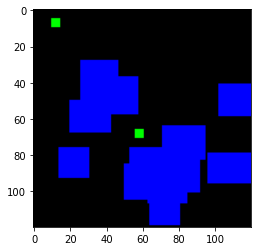

In [68]:
train_features, train_labels = next(iter(train_encoder_dataloader))

display_image(train_features[0])

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {0} device'.format(device))

Using cuda device


In [70]:
def batch_norm_conv(ni, nf, stride=1):
  return nn.Sequential(
    nn.BatchNorm2d(ni),
    nn.ReLU(inplace=True),
    nn.Conv2d(ni, nf, (3, 3), stride=stride, padding=1, bias=False)
  )

In [71]:
def conv1x1(ni, nf, stride=1):
  return nn.Sequential(
    nn.Conv2d(ni, nf, (1, 1), stride=stride),
    nn.BatchNorm2d(nf)
  )

In [72]:
class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride=1):
    super(ResBlock, self).__init__()
    self.shortcut = conv1x1(ni, nf, stride=stride)
    self.Bn1 = batch_norm_conv(ni, nf, stride=stride)
    self.Bn2 = batch_norm_conv(nf, nf)

  def forward(self, x):
    short = self.shortcut(x)
    x = self.Bn1(x)
    x = self.Bn2(x)
    return x.add(short)

In [74]:
class ResEncoder(nn.Module):

  def __init__(self):
    super(ResEncoder, self).__init__()

    self.short1 = conv1x1(2, 2)
    self.conv1 = nn.Conv2d(2, 2, (3, 3), padding=1)
    self.Bn1 = batch_norm_conv(2, 2)
    self.Res1 = ResBlock(2, 4)
    self.Res2 = ResBlock(4, 8, stride=2)
    self.Res3 = ResBlock(8, 16, stride=2)
    self.Res4 = ResBlock(16, 16, stride=2)

  def forward(self, x):

    r = self.short1(x)
    x = self.conv1(x)
    x = self.Bn1(x)
    x = x.add(r)
    short1 = torch.clone(x)

    x = self.Res1(x)
    short2 = torch.clone(x)
    x = self.Res2(x)
    short3 = torch.clone(x)
    x = self.Res3(x)
    short4 = torch.clone(x)
    x = self.Res4(x)

    return x, short1, short2, short3, short4

In [75]:
class ResDecoder(nn.Module):

  def __init__(self):
    super(ResDecoder, self).__init__()

    self.Up1 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.Up2 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.Up3 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.Up4 = nn.UpsamplingBilinear2d(scale_factor=1)

    self.Res5 = ResBlock(32, 8)
    self.Res6 = ResBlock(16, 4)
    self.Res7 = ResBlock(8, 2)
    self.Res8 = ResBlock(4, 2)

    self.conv2 = nn.Conv2d(2, 2, (1, 1))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, short1, short2, short3, short4):

    x = self.Up1(x)
    x = torch.cat((short4, x), dim=1)
    x = self.Res5(x)

    x = self.Up2(x)
    x = torch.cat((short3, x), dim=1)
    x = self.Res6(x)

    x = self.Up3(x)
    x = torch.cat((short2, x), dim=1)
    x = self.Res7(x)

    x = self.Up4(x)
    x = torch.cat((short1, x), dim=1)
    x = self.Res8(x)

    x = self.conv2(x)
    x = self.sigmoid(x)

    return x

In [76]:
class ResUNet(nn.Module):

  def __init__(self):
    super(ResUNet, self).__init__()

    self.Encoder = ResEncoder()
    self.Decoder = ResDecoder()

  def forward(self, x):

    x, short1, short2, short3, short4 = self.Encoder(x)
    x = self.Decoder(x, short1, short2, short3, short4)
    return x

model = ResUNet().to(device)
print(model.Encoder)
print(model.Decoder)

ResEncoder(
  (short1): Sequential(
    (0): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Bn1): Sequential(
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (Res1): ResBlock(
    (shortcut): Sequential(
      (0): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Bn1): Sequential(
      (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (Bn2): Sequential(
      (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, a

In [94]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [95]:
def train(dataloader, model, loss_fn, optimizer):

  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    #print(pred.shape, y.shape)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

In [96]:
def test(dataloader, model, loss_fn):

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  # correct /= size
  print(f'Test Error: \n Accuracy: {(np.nan):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [108]:
epochs = 100
for t in range(epochs):
  print(f'Epoch {t+1}\n-------------------------------')
  train(train_encoder_dataloader, model, loss_fn, optimizer)
  test(test_encoder_dataloader, model, loss_fn)
print('Done!')

Epoch 1
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 2
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 3
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 4
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 5
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 6
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 1800]
Test Error: 
 Accuracy: nan%, Avg loss: 0.000000 

Epoch 7
-------------------------------
loss: 0.000000  [    0/ 1800]
loss: 0.000000  [ 1600/ 

torch.Size([2, 120, 120])


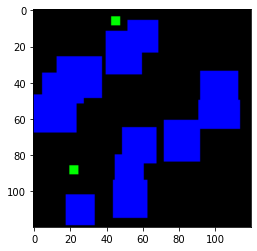

torch.Size([2, 120, 120])


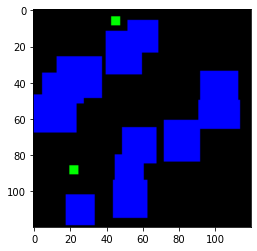

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 120, 120])


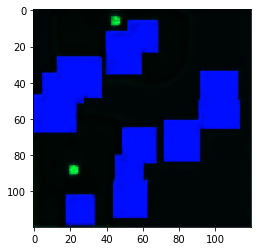

torch.Size([16, 15, 15])


In [109]:
test_features, test_labels = next(iter(test_encoder_dataloader))
display_image(test_features[0])
display_image(test_labels[0])

result = model(test_labels.to(device))
result = result.cpu()
display_image(result[0])
print(model.Encoder(test_labels.to(device))[0][0].shape)